# Gradient Boost Regressor - Model Evaluation

In [8]:
# standard modules
import sys
import os

# data and vizualisation models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# machine learning
import joblib
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_validate, learning_curve, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Get the current working directory
current_dir = os.getcwd()

# add 'main' to the path
main_dir = os.path.dirname(current_dir)
sys.path.append(main_dir)

# data preprocessing and scaling
from feature_engin.feature_import import combine_dataframes


Downloading the preprocessed and scaled (only traget not scaled) dataset from Google Cloud Bucket

In [9]:
# fetching data
raw_data = combine_dataframes()
# copying
data = raw_data.copy()
data.info()


Loaded coal_price.csv successfully.
Loaded ttf_price.csv successfully.
Loaded oil_price.csv successfully.
Loaded germany_electricity_generation_2018-2023.csv successfully.
Loaded holidays.csv successfully.
Loaded PMI_germany.csv successfully.
Loaded weather_north_hourly.csv successfully.
Loaded weather_south_hourly.csv successfully.
Loaded weather_brocken_hourly.csv successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199389 entries, 2018-01-02 00:00:00+00:00 to 2023-11-22 00:00:00+00:00
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   coal_adj_close          199389 non-null  float64
 1   ttf_adj_close           199389 non-null  float64
 2   ttf_volume              199389 non-null  float64
 3   oil_adj_close           199389 non-null  float64
 4   oil_volume              199389 non-null  float64
 5   fractional_hour         199389 non-null  float64
 6   day_of_week            

In [10]:
# sortby the datetime index
data = data.sort_index()

# Identify the Split Point
split_date = data.index.max() - pd.Timedelta(weeks=2)

data_mod = data[data.index <= split_date]
last_two_weeks_data = data[data.index > split_date]

# Check the number of entries in the split datasets
print("Data up to the last two weeks:", data_mod.shape[0])
print("Last two weeks data:", last_two_weeks_data.shape[0])


Data up to the last two weeks: 198045
Last two weeks data: 1344


In [11]:
last_two_weeks_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2023-11-08 00:15:00+00:00 to 2023-11-22 00:00:00+00:00
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   coal_adj_close          1344 non-null   float64
 1   ttf_adj_close           1344 non-null   float64
 2   ttf_volume              1344 non-null   float64
 3   oil_adj_close           1344 non-null   float64
 4   oil_volume              1344 non-null   float64
 5   fractional_hour         1344 non-null   float64
 6   day_of_week             1344 non-null   float64
 7   week_of_year            1344 non-null   float64
 8   month                   1344 non-null   float64
 9   year                    1344 non-null   float64
 10  hydro_storage_in        1344 non-null   float64
 11  cross_border            1344 non-null   float64
 12  nuclear                 1344 non-null   float64
 13  hydro                   1344 non-null   float

In [12]:
# Separating the features and the target variable from the original dataset
X = data_mod.drop(columns=['day_ahead_price'])
y = data_mod['day_ahead_price']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Features for MinMaxScaler and RobustScaler as defined by the user
features_min_max_scaler = ['coal_adj_close', 'ttf_adj_close', 'ttf_volume', 'oil_adj_close', 'oil_volume', "actual_pmi"]
features_robust_scaler = ['windspeed_north', 'windspeed_south', 'windspeed_brocken']

# Remaining features for StandardScaler, excluding the 'Unnamed: 0' column
features_standard_scaler = [col for col in data.columns if col not in features_min_max_scaler + features_robust_scaler + ['Unnamed: 0', 'day_ahead_price']]

# Redefining the scalers and transformers with the adjusted feature lists
standard_scaler_transformer = Pipeline(steps=[
    ('standard_scaler', StandardScaler())
])

min_max_scaler_transformer = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler())
])

robust_scaler_transformer = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# Combining the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', standard_scaler_transformer, features_standard_scaler),
        ('minmax_scaler', min_max_scaler_transformer, features_min_max_scaler),
        ('robust_scaler', robust_scaler_transformer, features_robust_scaler)
    ],
    remainder='drop'  # Non-scaled columns are deleted
)


In [14]:
# Applying the scaling pipeline separately to the training and testing sets
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


# Gradient Boost Regressor
## Instantiate the Gradient Boost Regressor Model

- Scoring method is R^2 to penalize high errors with huber loss function
- best model after extensive gridsearch
- increased max dept to improve model fitting
- huber loss to decrease error for extreme values (option: tweaking alpha value)

In [15]:
# Best parameters from your previous grid search, with 'huber' loss
best_params_huber = {
    'n_estimators': 300,
    'learning_rate': 0.2,
    'max_depth': 12,
    'loss': 'huber',
    'min_samples_split': 10
}

# Create the model with 'huber' loss
best_gbr = GradientBoostingRegressor(**best_params_huber, random_state=42)

# Training the model
best_gbr.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred = best_gbr.predict(X_test_scaled)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Displaying the evaluation metrics
print("Mean Absolute Error with 'huber' loss:", mae)
print("Mean Squared Error with 'huber' loss:", mse)
print("R² Score with 'huber' loss:", r2)


Mean Absolute Error with 'huber' loss: 3.0117772876411846
Mean Squared Error with 'huber' loss: 42.27641982633673
R² Score with 'huber' loss: 0.995771307232727


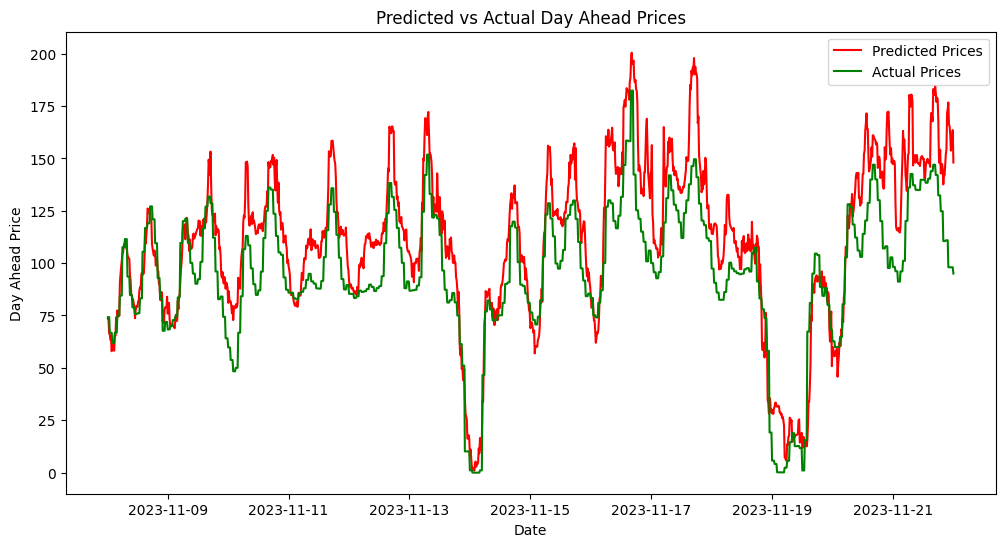

In [16]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices= best_gbr.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices, label='Predicted Prices', color='red')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()


## Feature importance

Checking if feature weighting is in accordance to domain knowledge:

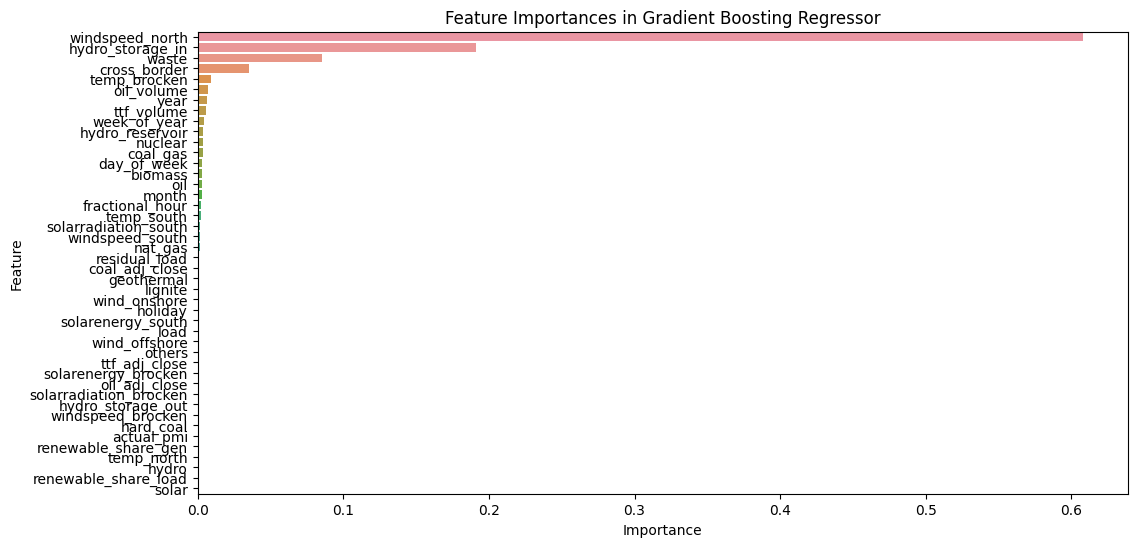

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve feature importances from the model
feature_importances = best_gbr_LC.feature_importances_

# Assuming X_train_scaled is a DataFrame or you have the feature names list
# Replace 'X_train.columns' with the actual feature names if X_train_scaled is not a DataFrame
feature_names = X_train.columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting the features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


deleting waste and coal_gas form pipeline:

- waste and coal_gas energy accounts for marginal amounts of electricity generation
- deleting features will lead to emphasis of more important features

In [30]:
# Update feature lists by removing 'waste' and 'coal_gas'
features_standard_scaler_mod = [f for f in features_standard_scaler if f not in ['waste', 'coal_gas']]

print(features_standard_scaler_mod)

# Recreate the scalers and transformers with the updated feature lists
standard_scaler_transformer_mod = Pipeline(steps=[
    ('standard_scaler', StandardScaler())
])
min_max_scaler_transformer_mod = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler())
])
robust_scaler_transformer_mod = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# Recreate the combined transformer
preprocessor_mod = ColumnTransformer(
    transformers=[
        ('std_scaler', standard_scaler_transformer_mod, features_standard_scaler_mod),
        ('minmax_scaler', min_max_scaler_transformer_mod, features_min_max_scaler),
        ('robust_scaler', robust_scaler_transformer_mod, features_robust_scaler)
    ],
    remainder='drop',
)

# Apply the modified scaling transformation to the original datasets
X_train_scaled_mod = preprocessor_mod.fit_transform(X_train)
X_test_scaled_mod = preprocessor_mod.transform(X_test)

# Train and evaluate the model as before
best_gbr_mod = GradientBoostingRegressor(**best_params_huber, random_state=42)
best_gbr_mod.fit(X_train_scaled_mod, y_train)

y_pred_mod = best_gbr_mod.predict(X_test_scaled_mod)
mae_mod = mean_absolute_error(y_test, y_pred_mod)
mse_mod = mean_squared_error(y_test, y_pred_mod)
r2_mod = r2_score(y_test, y_pred_mod)

print("Mean Absolute Error:", mae_mod)
print("Mean Squared Error:", mse_mod)
print("R² Score:", r2_mod)


['fractional_hour', 'day_of_week', 'week_of_year', 'month', 'year', 'hydro_storage_in', 'cross_border', 'nuclear', 'hydro', 'biomass', 'lignite', 'hard_coal', 'oil', 'nat_gas', 'geothermal', 'hydro_reservoir', 'hydro_storage_out', 'others', 'wind_offshore', 'wind_onshore', 'solar', 'load', 'residual_load', 'renewable_share_gen', 'renewable_share_load', 'holiday', 'temp_north', 'temp_south', 'solarradiation_south', 'solarenergy_south', 'temp_brocken', 'solarradiation_brocken', 'solarenergy_brocken']
Mean Absolute Error: 2.9560015194425353
Mean Squared Error: 40.62397212086761
R² Score: 0.9959365930750267


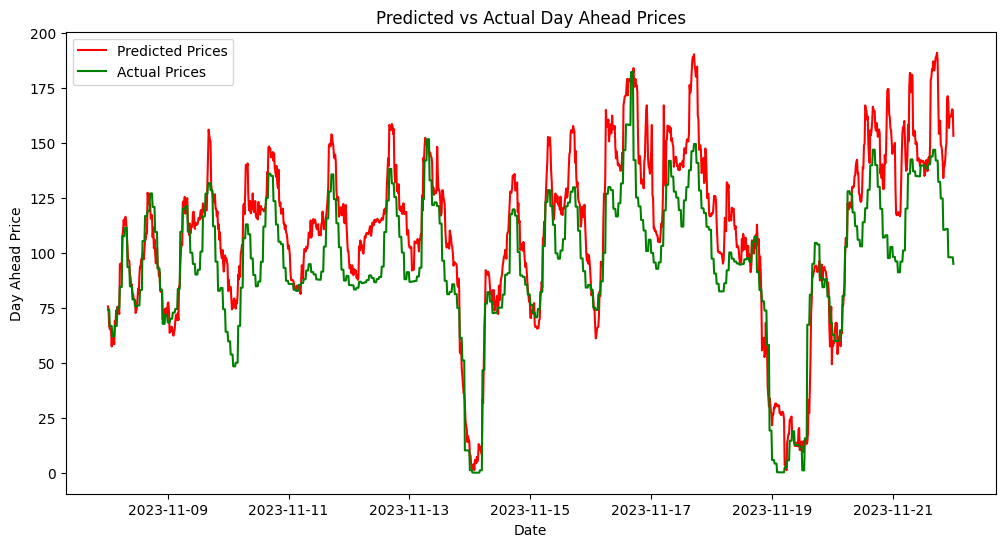

In [ ]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor_modified.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_mod= best_gbr_mod.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_mod, label='Predicted Prices', color='red')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()


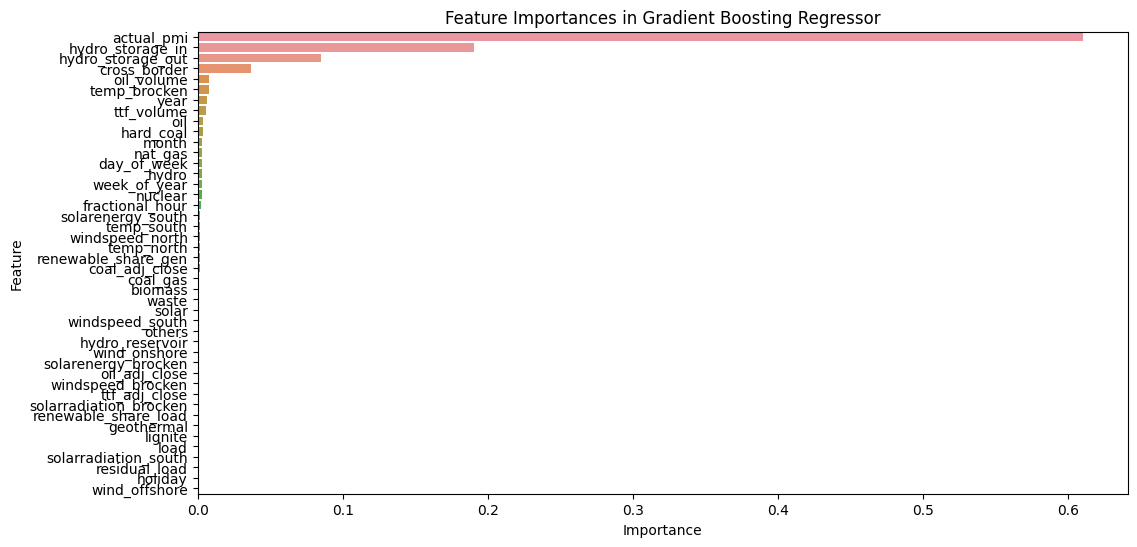

In [ ]:
# Retrieve feature importances from the model
feature_importances = best_gbr_mod.feature_importances_

# Assuming X_train_scaled is a DataFrame or you have the feature names list
# Replace 'X_train.columns' with the actual feature names if X_train_scaled is not a DataFrame
feature_names = X_train.columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting the features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Scaling the electricity generation data with a MinMaxScaler instead of a StandardScaler to retain the magnitude of the data

In [31]:
# Features for MinMaxScaler and RobustScaler as defined by the user
features_min_max_scaler = ['coal_adj_close', 'ttf_adj_close', 'ttf_volume', 'oil_adj_close', 'oil_volume', "actual_pmi", 'hydro_storage_in', 'cross_border', 'nuclear', 'hydro', 'biomass', 'lignite', 'hard_coal', 'oil', 'nat_gas', 'geothermal', 'hydro_reservoir', 'hydro_storage_out', 'others', 'wind_offshore', 'wind_onshore', 'solar', 'load', 'residual_load',]
features_robust_scaler = ['windspeed_north', 'windspeed_south', 'windspeed_brocken']

# Remaining features for StandardScaler, excluding the 'Unnamed: 0' column
features_standard_scaler = [col for col in data.columns if col not in features_min_max_scaler + features_robust_scaler + ['Unnamed: 0', 'day_ahead_price', 'waste', 'coal_gas']]

print(features_standard_scaler)
print(features_min_max_scaler)
print(features_robust_scaler)


['fractional_hour', 'day_of_week', 'week_of_year', 'month', 'year', 'renewable_share_gen', 'renewable_share_load', 'holiday', 'temp_north', 'temp_south', 'solarradiation_south', 'solarenergy_south', 'temp_brocken', 'solarradiation_brocken', 'solarenergy_brocken']
['coal_adj_close', 'ttf_adj_close', 'ttf_volume', 'oil_adj_close', 'oil_volume', 'actual_pmi', 'hydro_storage_in', 'cross_border', 'nuclear', 'hydro', 'biomass', 'lignite', 'hard_coal', 'oil', 'nat_gas', 'geothermal', 'hydro_reservoir', 'hydro_storage_out', 'others', 'wind_offshore', 'wind_onshore', 'solar', 'load', 'residual_load']
['windspeed_north', 'windspeed_south', 'windspeed_brocken']


In [32]:
# Recreate the scalers and transformers with the updated feature lists
standard_scaler_transformer = Pipeline(steps=[
    ('standard_scaler', StandardScaler())
])
min_max_scaler_transformer = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler())
])
robust_scaler_transformer = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# Recreate the combined transformer
preprocessor_mod = ColumnTransformer(
    transformers=[
        ('std_scaler', standard_scaler_transformer, features_standard_scaler),
        ('minmax_scaler', min_max_scaler_transformer, features_min_max_scaler),
        ('robust_scaler', robust_scaler_transformer, features_robust_scaler)
    ],
    remainder='drop',
)

# Apply the modified scaling transformation to the original datasets
X_train_scaled = preprocessor_mod.fit_transform(X_train)
X_test_scaled = preprocessor_mod.transform(X_test)

# Train and evaluate the model as before
best_gbr_mod = GradientBoostingRegressor(**best_params_huber, random_state=42)
best_gbr_mod.fit(X_train_scaled, y_train)

y_pred_mod = best_gbr_mod.predict(X_test_scaled)
mae_mod = mean_absolute_error(y_test, y_pred_mod)
mse_mod = mean_squared_error(y_test, y_pred_mod)
r2_mod = r2_score(y_test, y_pred_mod)

print("Mean Absolute Error:", mae_mod)
print("Mean Squared Error:", mse_mod)
print("R² Score:", r2_mod)


Mean Absolute Error: 2.9841190245196776
Mean Squared Error: 40.46335215576581
R² Score: 0.9959526590637622


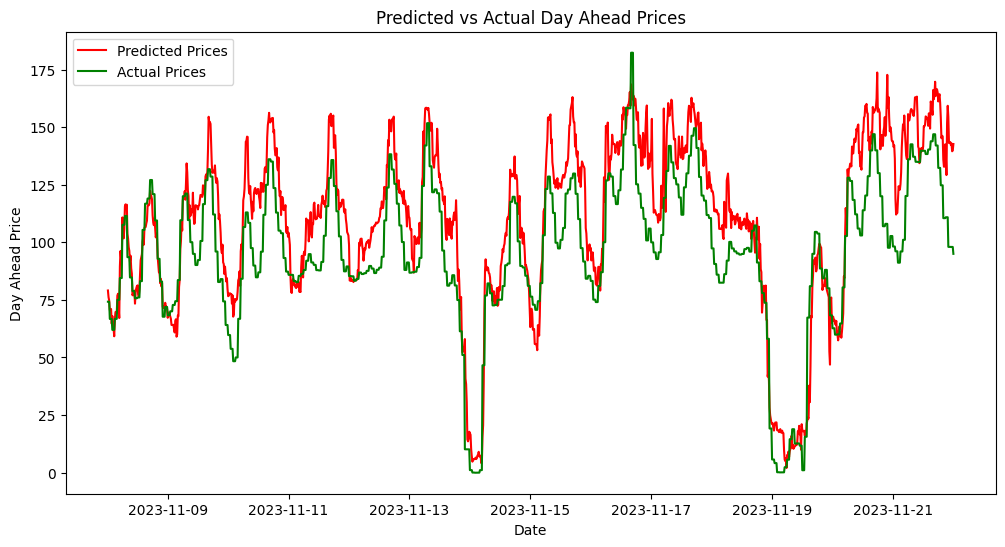

In [33]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor_mod.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_mod= best_gbr_mod.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_mod, label='Predicted Prices', color='red')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()


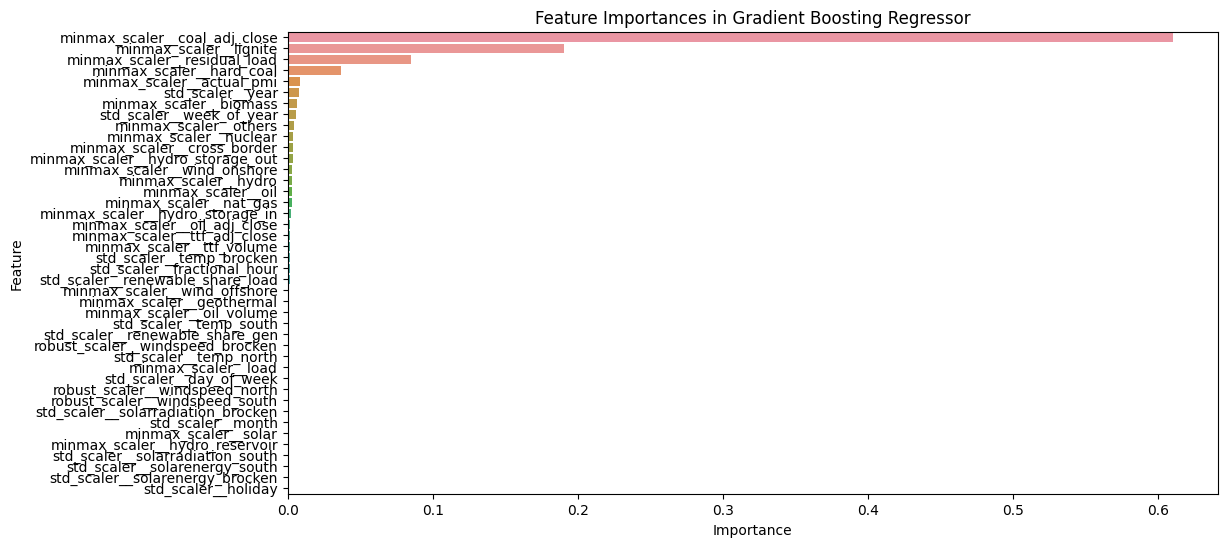

In [36]:
# Retrieve feature importances from the model
feature_importances = best_gbr_mod.feature_importances_

# Extract feature names from the preprocessor
feature_names_modified = preprocessor_mod.get_feature_names_out()

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_modified,
    'Importance': feature_importances
})

# Sorting the features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


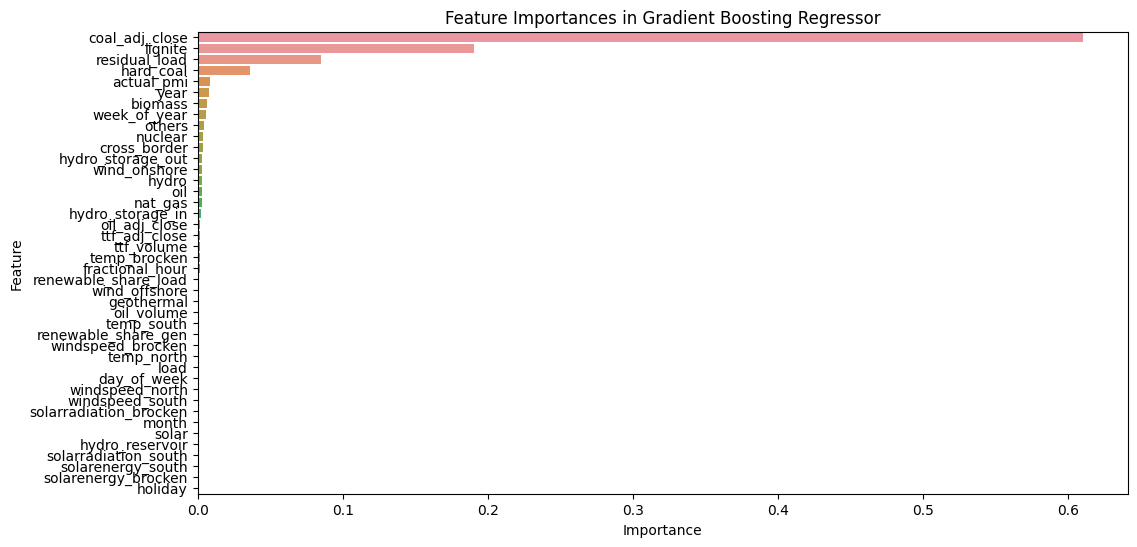

In [37]:
# Extract transformed feature names
transformed_feature_names = preprocessor_mod.get_feature_names_out()

# Original feature names before transformation
original_feature_names = X_train.columns.tolist()

# Mapping transformed names back to original names
# Assuming the original names are simply appended with a prefix in the transformed names
mapped_feature_names = [name.split('__')[-1] for name in transformed_feature_names if name.split('__')[-1] in original_feature_names]

# Retrieve feature importances from the model
feature_importances = best_gbr_mod.feature_importances_

# Ensure the length matches
if len(mapped_feature_names) == len(feature_importances):
    # Create a DataFrame for better readability
    feature_importance_df = pd.DataFrame({
        'Feature': mapped_feature_names,
        'Importance': feature_importances
    })

    # Sorting the features based on importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plotting feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances in Gradient Boosting Regressor')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Mismatch in the number of features.")


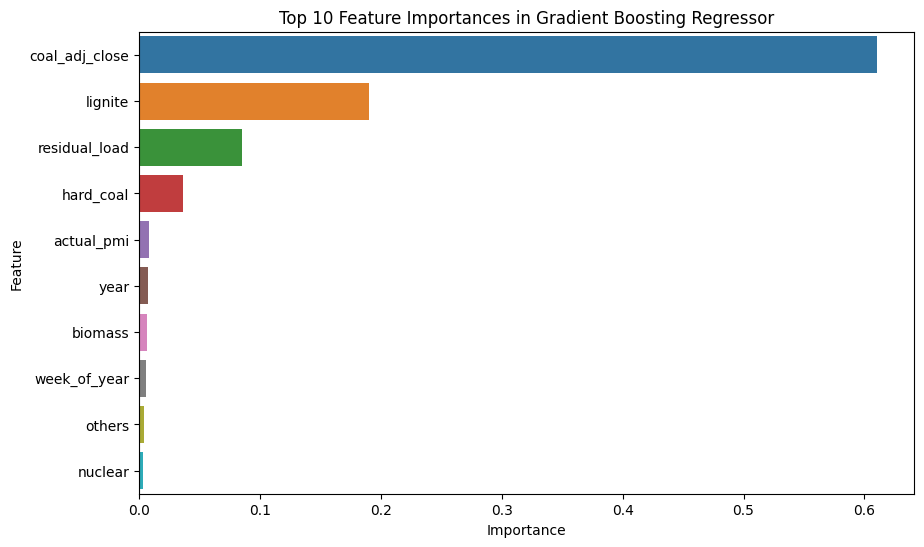

In [38]:
# Retrieve feature importances from the model
feature_importances = best_gbr_mod.feature_importances_

# Extract transformed feature names
transformed_feature_names = preprocessor_mod.get_feature_names_out()

# Mapping transformed names back to original names
mapped_feature_names = [name.split('__')[-1] for name in transformed_feature_names]

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': mapped_feature_names,
    'Importance': feature_importances
})

# Sorting the features based on importance and selecting the top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting feature importances for the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Feature Importances in Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


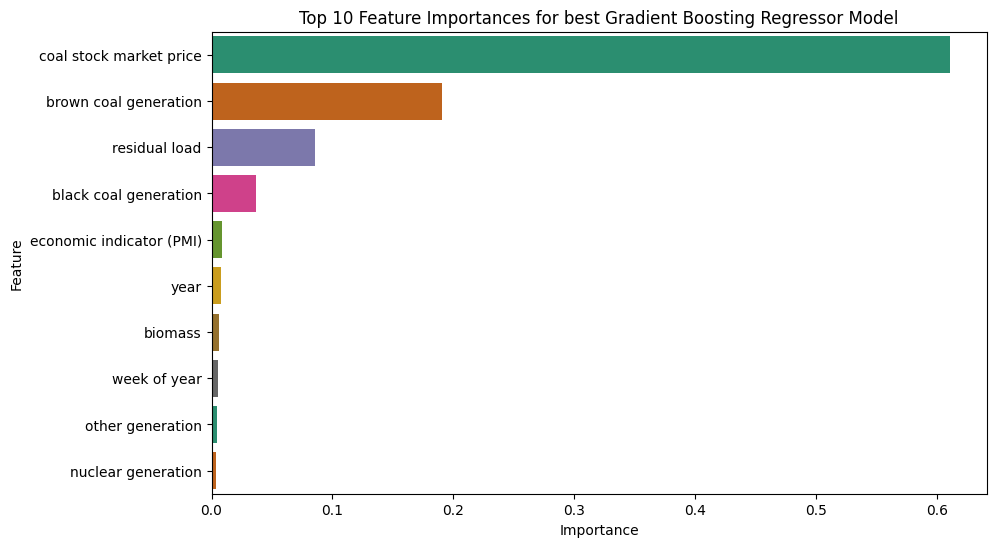

In [50]:
# Define a mapping from the original feature names to the new names
feature_name_mapping = {
    'coal_adj_close': 'coal stock market price',
    'lignite': 'brown coal generation',
    'residual_load': 'residual load',
    'hard_coal': 'black coal generation',
    'actual_pmi': 'economic indicator (PMI)',
    'year': 'year',
    'biomass': 'biomass',
    'week_of_year': 'week of year',
    'others': 'other generation',
    'nuclear': 'nuclear generation'
}

# Apply the mapping to your DataFrame
top_10_features['Feature'] = top_10_features['Feature'].map(feature_name_mapping).fillna(top_10_features['Feature'])

# Plotting feature importances for the top 10 features with updated names
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette="Dark2")
plt.title('Top 10 Feature Importances for best Gradient Boosting Regressor Model')
plt.xlabel('Importance')
plt.show()


## Learning Curve for GBR

starts with very tiny dataset(3%)

In [17]:
# Sizes for training (percentages of the full training set)
train_sizes = [0.03, 0.07, 0.12, 0.20, 0.45, 0.70, 1.00]

# Lists to store the performance metrics for each training size
mae_scores = []
r2_scores = []

for size in train_sizes:
    # Split the original training data to the current size
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, train_size=size, random_state=42)

    # Create the model
    best_gbr_LC = GradientBoostingRegressor(**best_params_huber, random_state=42)

    # Train the model
    best_gbr_LC.fit(X_train_subset, y_train_subset)

    # Predict on the full test set
    y_pred = best_gbr_LC.predict(X_test_scaled)

    # Calculate performance metrics
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))


InvalidParameterError: The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 1.0 instead.

In [ ]:
# Plotting the learning curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, mae_scores, label='MAE', marker='o')
plt.title('Learning Curve (MAE)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Error')

plt.subplot(1, 2, 2)
plt.plot(train_sizes, r2_scores, label='R2 Score', marker='o')
plt.title('Learning Curve (R2 Score)')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')

plt.tight_layout()
plt.show()


# Evaluating Best GBR Model

## Training MSE and R^2

In [114]:
best_gbm_model = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, min_samples_split=10, random_state=42)

best_gbm_model.fit(X_train, y_train)

# Save the model to a file
joblib.dump(best_gbm_model, 'best_gbm_model.pkl')


# Predict on the training data
y_train_pred = best_gbm_model.predict(X_train)

# Calculate and print the performance metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Training R-squared: {r2_train}")


Training Mean Squared Error: 0.0032801230324506912
Training R-squared: 0.9967143268050016


## Test MSE and R^2

In [115]:
y_test_pred = best_gbm_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R-squared: {r2_test}")


Test Mean Squared Error: 0.006760460493644192
Test R-squared: 0.9934663063399206


## Cross-validation of MSE and R^2

In [97]:
# Instantiate the model with the optimal hyperparameters
best_gbm_model_cv = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, min_samples_split=10, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_gbm_model_cv, X_train, y_train, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean R-squared: {cv_mean:.4f}, Standard Deviation: {cv_std:.4f}")


Cross-Validation R-squared Scores: [0.99302618 0.99317717 0.99286773 0.99268422 0.99272454]
Mean R-squared: 0.9929, Standard Deviation: 0.0002


# Check Feature Importance

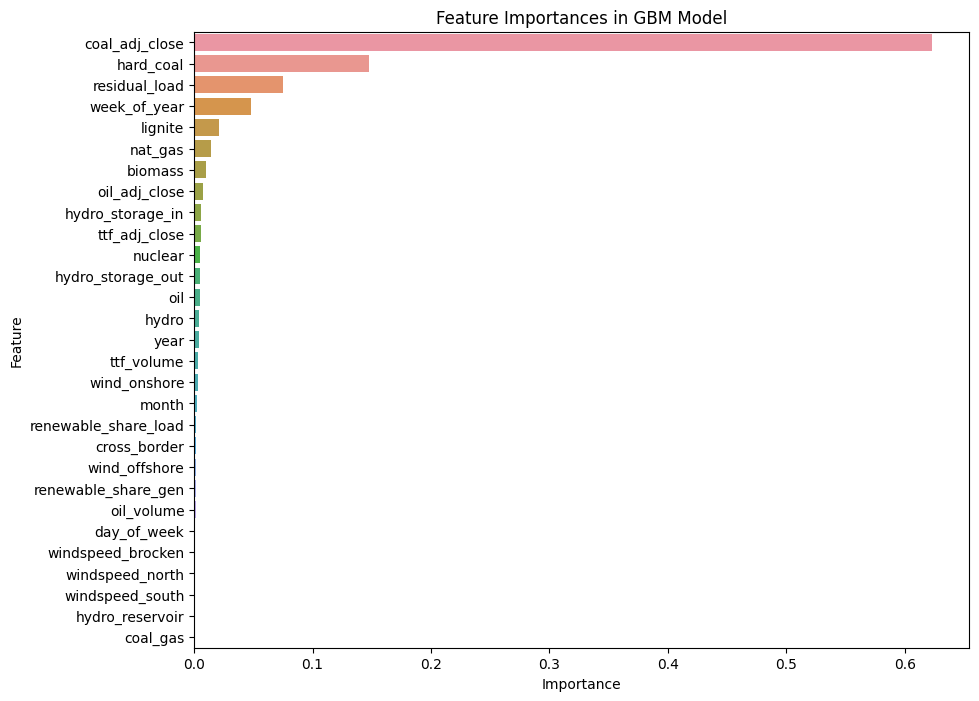

In [116]:
feature_importances = best_gbm_model.feature_importances_

# extract feature importances and create df to plot
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Make barplot of feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features)
plt.title('Feature Importances in GBM Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Error Analysis

Obtain predictions and residuals:

In [117]:
# Predictions
y_train_pred = best_gbm_model.predict(X_train)
y_test_pred = best_gbm_model.predict(X_test)

# Residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred


### Plot Residuals

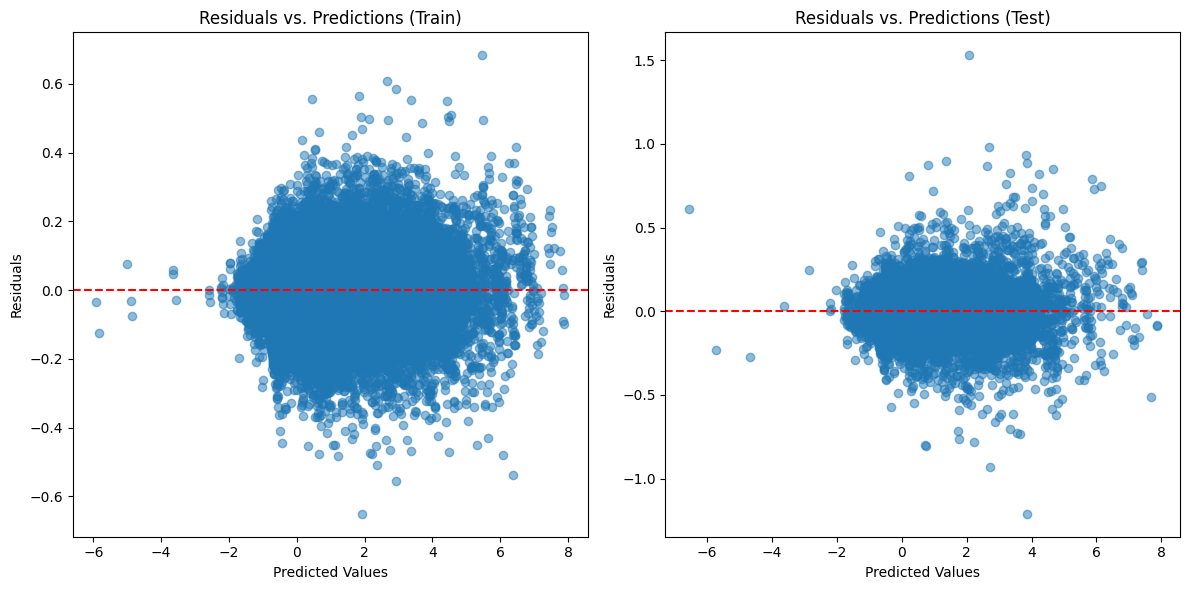

In [118]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residuals, alpha=0.5)
plt.title('Residuals vs. Predictions (Train)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residuals, alpha=0.5)
plt.title('Residuals vs. Predictions (Test)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()


### Plot Distribution of Residuals

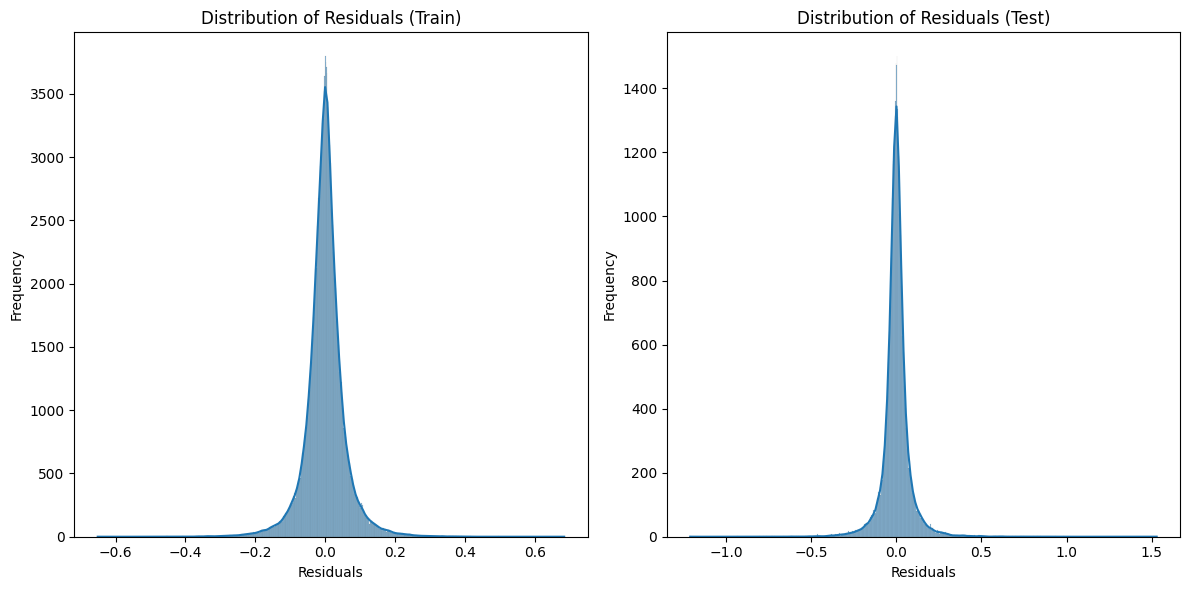

In [119]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True)
plt.title('Distribution of Residuals (Train)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True)
plt.title('Distribution of Residuals (Test)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Finalize the Model

fit with full dataset (before train test split)

In [14]:
# Train Full model
gbm_final = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, random_state=42, min_samples_split=10,)
gbm_final.fit(X, y)  # X and y represent our full dataset

# Save the model
joblib.dump(gbm_final, 'gbm_final_opt_model.pkl')


['gbm_final_opt_model.pkl']

# Predict and Plot

Predicting the Day-Ahead-Prices of the last two weeks 

In [15]:
# dataset contains the scaled target -> drop it
X_last_two_weeks_data = last_two_weeks_data.drop('day_ahead_price_scaled', axis=1)


In [16]:
# Make prediction
y_pred_last_two_weeks = gbm_final.predict(X_last_two_weeks_data)


In [17]:
# Compare Predictions with Actual Values
actual_prices = last_two_weeks_data['day_ahead_price_scaled'].values
predicted_prices = y_pred_last_two_weeks  # the predictions

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({'Actual Price': actual_prices, 'Predicted Price': predicted_prices})


In [22]:
actual_prices = last_two_weeks_data['day_ahead_price_scaled'].values
predicted_prices = y_pred_last_two_weeks  # the predictions

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({'Actual Price': actual_prices, 'Predicted Price': predicted_prices})


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 0.44594597372150235
Mean Squared Error: 0.37225971796624374
R-squared: -1.8589223215507702


In [24]:
# Inverse_transform with our StandardScaler instance used for the target variable
predicted_prices_unscaled = scaler.inverse_transform(predicted_prices.reshape(-1, 1)).flatten()

# Retrieving the actual unscaled prices
actual_prices_unscaled = unscaled_target.loc[last_two_weeks_data.index].values.flatten()


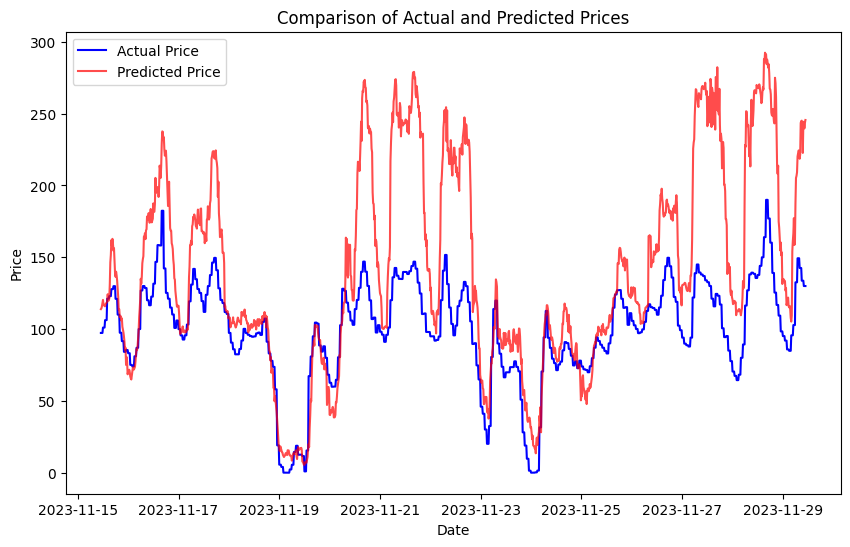

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(last_two_weeks_data.index, actual_prices_unscaled, label='Actual Price', color='blue')
plt.plot(last_two_weeks_data.index, predicted_prices_unscaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Problem: scaling test and train data with same scaler leads to data leakage!!!!!

# Optional: Learning Curve for Final Model

Attention: Compuationally heavy

In [ ]:
import numpy as np
train_sizes = np.linspace(0.1, 1.0, 10)  # For example, 10% to 100% of the training data

from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, min_samples_split=10, random_state=42),
    X = X,  # Your full dataset
    y = y,  # Target values
    train_sizes = train_sizes,
    cv = 5,  # Number of folds in cross-validation
    scoring = 'r2'  # Scoring metric
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R-squared Score")
plt.legend(loc="best")
plt.grid()
plt.show()
